# Chapter 3


`Conteúudo originamente criado por Cam Davidson-Pilon`

`Transferido para Python 3 e PyMC3 por Max Margenot (@clean_utensils) e Thomas Wiecki (@twiecki) em Quantopian (@quantopian)`
____

Versão pt_BR

Tradução por Rodolpho Macedo dos Santos disponibilizado em [Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](http://github.com/rodolphomacedo/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)


## Abrindo a caixa preta do MCMC

Os dois capítulos anteriores esconderam do leitor a mecânica interna do PyMC3 e, mais geralmente, do Markov Chain Monte Carlo (MCMC). O motivo para incluir este capítulo é triplo. A primeira é que qualquer livro sobre inferência bayesiana deve discutir MCMC. Eu não posso lutar contra isso. Culpe os estatísticos. Em segundo lugar, conhecer o processo de MCMC dá uma ideia se o seu algoritmo convergiu. (Convergido para o quê? Chegaremos a isso) Em terceiro lugar, vamos entender *por que* recebemos milhares de amostras da posteriori como uma solução, o que à primeira vista pode ser estranho.

### A superfície Bayesiano

Quando construimos um problema de inferência Bayesiana com $N$ incógnitas, estamos criando implicitamente um espaço dimensional de tamanho $N$ para as distribuições posteriori existirem. Associado a esse espaço está uma dimensão adicional, que podemos descrever como a *superfície*, ou *curva*, que fica na parte superior do espaço, que reflete a *probabilidade a priori* de um determinado ponto. Essa superfície do espaço é definida por nossas distribuições a prioris. Por exemplo, se tivermos duas incógnitas $p_1$ e $p_2$, e as prioris de ambas forem $\text{Uniform}(0, 5)$, o espaço criado é um quadrado de comprimento 5 e a superfície é um plano plano que fica na parte superior desse quadrado (representando que cada ponto é igualmente provável).

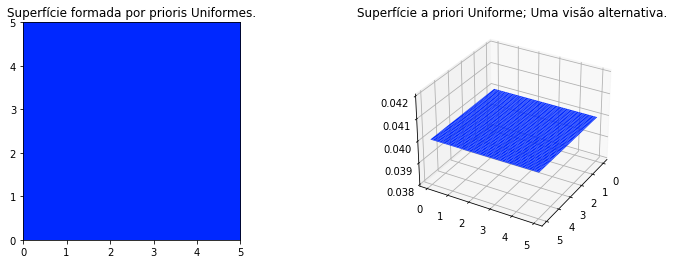

In [7]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície formada por prioris Uniformes.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Superfície a priori Uniforme; Uma visão alternativa.");

Alternativamente, se as duas prioris são $\text{Exp}(3)$ e $\text{Exp}(10)$, então o espaço contém todos números positivos no plano 2-D, e a superfície induzida pelas prioris parecem uma queda d'água que começa no ponto (0,0) e flui sobre os números positivos.

Os gráficos abaixo mostram isso. Quanto mais vermelho escuro for a cor, maior será a probabilidade a priori atribuída a esse ponto. Por outro lado, as áreas com azul mais escuro representam que nossas prioris atribuem probabilidade muito baixa para esses pontos.

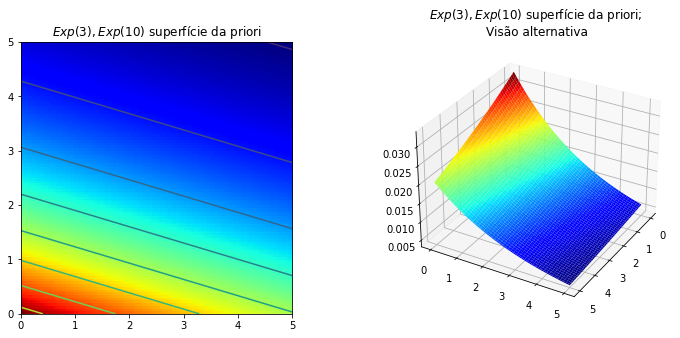

In [8]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ superfície da priori")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ superfície da priori; \nVisão alternativa");

Estes são exemplos simples no espaço 2D, onde nossos cérebros podem entender bem as superfícies. Na prática, os espaços e superfícies gerados por nossas prioris podem ser espaços dimensionais muito superiores.

Se essas superfícies descrevem nossas *distribuições a posteriori* nas incógnitas, o que acontece com nosso espaço depois que incorporamos nossos dados observados $X$? Os dados $X$ não mudam o espaço, mas mudam a superfície do espaço *puxando e esticando o tecido da superfície a priori* para refletir onde os verdadeiros parâmetros provavelmente residem. Mais dados significam mais puxões e esticões, e nossa forma original se torna multilada ou insignificante em comparação com a forma recém-formada. Com menos dados a nossa forma original estará mais presente. Independentemente disso, a superfície resultante descreve a *distribuição a posteriori*.



Mais uma vez devo enfatizar que é, infelizmente, impossível visualizar isso em grandes dimensões. Para duas dimensões, os dados essencialmente *empurram* a superfície original para formar *montanhas altas*. A tendência dos dados observados de *empurrar para cima* a probabilidade posteriori em certas áreas é verificada pela distribuição de probabilidade a priori, de modo que menos probabilidade a priori significa mais resistência. Assim, no caso anterior duplo-exponencial acima, uma montanha (ou várias montanhas) que poderia entrar em erupção perto do canto (0,0) seria muito mais alta do que montanhas que irromperiam mais perto de (5,5), uma vez que há mais resistência (baixa probabilidade a priori) próximo a (5,5). O pico reflete a probabilidade a posteriori de onde os verdadeiros parâmetros provavelmente serão encontrados. É importante ressaltar que se a priori atribuiu uma probabilidade de 0, nenhuma probabilidade posterior será atribuída lá.

Suponha que as prioris mencionadas acima representem diferentes parâmetros $\lambda$ de duas distribuições de Poisson. Observamos alguns pontos de dados e visualizamos a nova paisagem:

In [4]:
# criar os dados observados

# tamanho da amostra de dados que nós observamos, tente variar esse parâmetro (mantenha-o menor que 100;)
N = 1

# Esses são parâmetros verdadeiros, mas é claro que não conhecemos esses valores ...
lambda_1_true = 1
lambda_2_true = 3

# ... nós vemos os dados gerados, dependendo dos dois valores acima.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observando (bi-dimensional,tamanho da amostra = %d):" % N, data)

# Plotando os detalhes.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])


observando (bi-dimensional,tamanho da amostra = 1): [[1 6]]


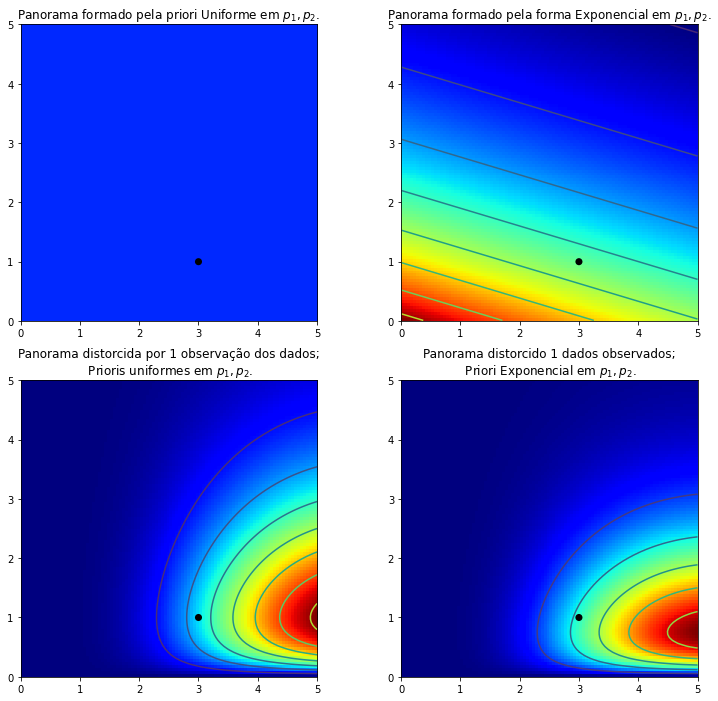

In [6]:
figsize(12.5, 12)
# rodar o matplotlib abaixo poderá ser pesado, cuidado!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície formada pela priori Uniforme em $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Superfície distorcida por %d observação dos dados;\n Prioris uniformes em $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície formada pela forma Exponencial em $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Superfície distorcida %d dados observados;\n Priori Exponencial em \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


O gráfico à esquerda é a superfície deformada com as prioris $\text{Uniform}(0, 5)$, e o gráfico à direita é a superfície deformada com as prioris exponenciais. Observe que as superfícies a posteriori parecem diferentes umas das outras, embora os dados observados sejam idênticos em ambos os casos. A razão é a seguinte. Observe que a superfície a priori exponencial, figura inferior direita, atribui muito pouco peso *a posteriori* aos valores no canto superior direito da figura: isso ocorre porque *a priori não coloca muito peso ali*. Por outro lado, a superfície a priori uniforme fica feliz em colocar peso a posteriori no canto superior direito, assim como a priori coloca mais peso ali.

Observe também que o ponto mais alto, correspondendo ao vermelho mais escuro, está inclinado para (0,0) no caso exponencial, que é o resultado do exponencial a priori de colocar mais peso a priori no canto (0,0).


O ponto preto representa os verdadeiros parâmetros. Mesmo com 1 ponto de amostra, as montanhas tentam conter o parâmetro verdadeiro. É claro que a inferência com um tamanho de amostra 1 é incrivelmente ingênua, e escolher um tamanho de amostra tão pequeno foi apenas ilustrativo.

É um ótimo exercício tentar mudar o tamanho da amostra para outros valores (tentar 2, 5, 10, 100?...) e observar como a nossa "montanha" a posteriori mudará.

### Explorando a superfície usando MCMC

Devemos explorar o espaço a posteriori deformado que foi gerado por nossa superfície a priori e os dados observados para encontrar a montanha a posteriori. No entanto, não podemos ingenuamente pesquisar esse espaço: qualquer cientista da computação dirá que atravessar o espaço $N$-dimensional é exponencialmente difícil em $N$: o tamanho do espaço aumenta rapidamente à medida que aumentamos $N$ (veja [o maldição da dimensionalidade] (http://en.wikipedia.org/wiki/Curse_of_dimensionality)). Que esperança temos de encontrar essas montanhas escondidas? A ideia por trás do MCMC é realizar uma busca inteligente do espaço. Quando dizemos "busca" isso implica que estamos procurando um ponto específico, o que talvez não seja preciso, pois estamos realmente procurando uma montanha larga.

Lembre-se de que MCMC retorna *amostras* da distribuição a posteriori, e não a distribuição em si. Estendendo nossa analogia montanhosa ao seu limite, MCMC realiza uma tarefa semelhante a perguntar repetidamente "Qual a probabilidade de esta elevação que descobri ser da montanha que estou procurando?" E completa sua tarefa devolvendo milhares de elevações aceitas na esperança de reconstruir a montanha original. No jargão MCMC e PyMC3, a sequência retornada das "elevações" são as amostras, cumulativamente chamadas de *traces* (*traços, em português*).

Quando digo que o MCMC pesquisa de forma inteligente, estou realmente dizendo que o MCMC *esperançosamente* convergirá para as áreas de alta probabilidade da posteriori. MCMC faz isso explorando posições próximas e movendo-se para áreas com maior probabilidade. Novamente, talvez "convergir" não seja um termo preciso para descrever a progressão do MCMC. Convergência geralmente implica em mover-se em direção a um ponto no espaço, mas MCMC se move em direção a uma *área mais ampla* no espaço e anda aleatoriamente nessa área, pegando amostras daquela área.

#### Por que milhares de amostras?

A princípio, retornar milhares de samples ao usuário pode soar como uma forma ineficiente de descrever as distribuições a posterioris. Eu diria que isso é extremamente eficiente. Considere as possibilidades alternativas:

1. Retornar uma fórmula matemática para as "cadeias de montanhas" envolveria descrever uma superfície N-dimensional com picos e vales arbitrários.
2. Retornar o "pico" da superfície, embora matematicamente seja possível e também uma coisa sensata a se fazer, visto que o ponto mais alto corresponde à estimativa mais provável das incógnitas, ignorariamos a forma da superfície, que argumentamos anteriormente ser muito importante para determinar confiança a posteriori em locais desconhecidos desconhecidos.

Além das razões computacionais, provavelmente a razão mais forte para retornar amostras é que podemos facilmente usar a *Lei dos Números Grandes* para resolver problemas que de outra forma seriam intratáveis. Adiamento esta discussão para o próximo capítulo. Com as milhares de amostras, podemos reconstruir a superfície a posteriori, organizando-as em um histograma.

### Algoritmos para realizar MCMC

Existe uma grande família de algoritmos que executam MCMC. A maioria desses algoritmos pode ser expressa em alto nível da seguinte forma: (Detalhes matemáticos podem ser encontrados no apêndice.)

1. Comece na posição atual.
2. Proponha a mudança para uma nova posição (investigue uma elevação perto de você).
3. Aceite / Rejeite a nova posição com base na aderência da posição aos dados e distribuições a priori (pergunte se a elevação provavelmente veio da montanha).
4. 1. Se você aceitar: Mova para a nova posição. Volte para a Etapa 1.
   2. Caso contrário: Não mova para a nova posição. Volte para a Etapa 1.
5. Após um grande número de iterações, retorne todas as posições aceitas.

Desta forma, nos movemos na direção geral em para às regiões onde existem as distribuições a posteriori, e coletamos amostras com moderação durante essa viagem. Assim que alcançarmos a distribuição a posteriori, podemos facilmente coletar amostras, pois provavelmente todas pertencem à distribuição posterior.

Se a posição atual do algoritmo MCMC estiver em uma área de probabilidade extremamente baixa, o que geralmente é o caso quando o algoritmo começa (normalmente em um local aleatório no espaço), o algoritmo se moverá em direções *que provavelmente não são da posteriori*, mas estará fazendo o melhor que puder nessas proximidades. Assim, os primeiros movimentos do algoritmo não refletem a posteriori.

No pseudocódigo do algoritmo acima, observe que apenas a posição atual importa (as novas posições são investigadas apenas quando perto da posição atual). Podemos descrever essa propriedade como *falta de memória*, ou seja, o algoritmo não se importa *como* ele chegou à sua posição atual, apenas que está lá.

### Outras soluções de aproximação para a posteriori
Além do MCMC, existem outros procedimentos disponíveis para determinar as distribuições posteriores. Uma aproximação de Laplace é uma aproximação da posterior usando funções simples. Um método mais avançado é [Variational Bayes] (http://en.wikipedia.org/wiki/Variational_Bayesian_methods). Todos os três métodos, aproximações de Laplace, Bayes variacionais e MCMC clássico têm seus prós e contras. Iremos nos concentrar apenas no MCMC neste livro. Dito isso, meu amigo Imri Sofar gosta de classificar algoritmos MCMC como "eles são uma merda" ou "eles realmente são uma merda". Ele classifica o sabor particular de MCMC usado por PyMC3 como apenas *péssimo*;)

##### Exemplo: Clustering não supervisionado usando um modelo de mistura

Suponha que recebamos o seguinte conjunto de dados:

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


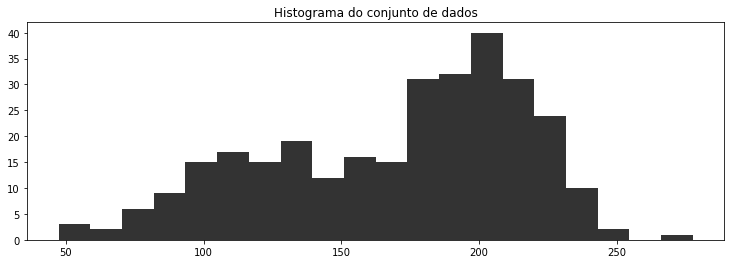

In [9]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histograma do conjunto de dados")
plt.ylim([0, None]);
print(data[:10], "...")


O que os dados sugerem? Parece que os dados têm uma forma bimodal, ou seja, parecem ter dois picos, um próximo a 120 e outro próximo a 200. Talvez haja *dois clusters* neste conjunto de dados.

Este conjunto de dados é um bom exemplo da técnica de modelagem de geração de dados do capítulo anterior. Podemos propor *como* os dados podem ter sido criados. Eu sugiro o seguinte algoritmo de geração de dados:

1. Para cada ponto, escolha o cluster 1 com probabilidade $p$, caso contrário, escolha o cluster 2.
2. Desenhe uma variável aleatória de uma distribuição normal com os parâmetros $\mu_i$ e $\sigma_i$, no qual onde $i$ foi escolhido na etapa anterior.
3. Repita.

Este algoritmo criará um efeito semelhante ao conjunto de dados observado, portanto, escolhemos isso como nosso modelo. Claro, não conhecemos $p$ ou os parâmetros das distribuições normais. Portanto, devemos inferir, ou *aprender*, esses parâmetros.

Denote as distribuições normais $\text{N}_0$ e $\text{N}_1$ (ter o índice das variáveis começando em 0 é apenas Pythônico). Ambos têm atualmente média e desvio padrão desconhecidos, denotados $\mu_i$ e $\sigma_i, \; i=0, 1$ respectivamente. Um ponto específico pode ser amostrado da $\text{N}_0$ ou $\text{N}_1$, e assumimos que o ponto é sorteado da $\text{N}_0$ com probabilidade $p$.

Uma maneira apropriada de atribuir os pontos a clusters é usar uma variável estocástica do PyMC3 `Categorical`. Seu parâmetro é um array de probabilidades (nesse caso, `p`) de comprimento $k$ que deve somar $1$ e seu atributo `value` é um número inteiro entre $0$ e $k-1$ escolhido aleatoriamente de acordo com o array de probabilidades criado (no nosso caso $k = 2$). *A priori*, não sabemos qual é a probabilidade que atribuiremos ao cluster 1, então construímos uma variável uniforme em $Uniform(0, 1)$. Chamamos ela de $p_1$, então a probabilidade de pertencer ao cluster 2 é, portanto, $p_2 = 1 - p_1$.

Infelizmente, não podemos simplesmente passar `[p1, p2]` à nossa variável `Categorical`. pois o PyMC3 usa Theano sob o capô para construir os modelos, então precisamos usar `theano.tensor.stack ()` para combinar $p_1$ e $p_2$ em um vetor que ele possa entender. Passamos esse novo vetor para a variável `Categorical`, bem como o parâmetro` testval` para dar à nossa variável uma ideia de por onde começar.

In [51]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("Atribuição à priori, com p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:35])

Atribuição à priori, com p = 0.50:
[0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1]


Olhando para o conjunto de dados acima, acho que os desvio padrões das duas normais são diferentes. Para manter a ignorância de quais podem ser os desvios padrões das normais, iremos inicialmente modelá-los como uniformes de $0$ a $100$. Incluiremos ambos os desvios padrões em nosso modelo usando uma única linha de código PyMC3:

    sds = pm.Uniform("sds", 0, 100, shape=2)

Observe que especificamos `shape = 2`: assim estaremos modelando os $\sigma$s como uma única variável no PyMC3. Observe que isso não induz uma necessária relação entre os dois $\sigma$s, simplesmente escrevemos assim para ser sucinto.


Também precisamos especificar nas prioris os centros dos clusters. Os centros são realmente os parâmetros $\mu$ das distribuições normais. Suas prioris podem ser modeladas por uma distribuição normal. Olhando para os dados, tenho uma ideia de onde os dois centros podem ser estimados; Eu acho que algo em torno de $120$ e $190$ respectivamente, embora não esteja muito confiante nessas estimativas feitas a olho nu. Portanto, irei definir $\mu_0 = 120, \mu_1 = 190$ e $\sigma_0 = \sigma_1 = 10$.

In [52]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers",
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # e combiná-los ela com as observações da amostra:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Atribuições aleatórias: \t", assignment.tag.test_value[:10], "...")
print("Atribuições do centro: \t\t", center_i.tag.test_value[:10], "...")
print("Atribuições do desvio padrão: \t", sd_i.tag.test_value[:10])

Atribuições aleatórias: 	 [0 1 1 1 0 1 0 0 1 0] ...
Atribuições do centro: 		 [120. 190. 190. 190. 120. 190. 120. 120. 190. 120.] ...
Atribuições do desvio padrão: 	 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]


Observe como continuamos a construir o modelo dentro do contexto de `Model()`. Isso adiciona automaticamente as variáveis que criamos ao nosso modelo (*model*). Enquanto trabalharmos dentro deste contexto, estaremos trabalhando com as mesmas variáveis que já definimos.

Da mesma forma, qualquer amostragem que fizermos no contexto de `Model()` será feita apenas no modelo em cujo contexto estamos trabalhando. Diremos ao nosso modelo para explorar o espaço que definimos até agora definindo os métodos de amostragem, neste caso `Metropolis()` para nossas variáveis contínuas e `ElemwiseCategorical()` para nossa variável categórica. Usaremos esses métodos de amostragem juntos para explorar o espaço usando `sample(iteractions, step)`, onde `iteractions` é o número de passos que você deseja que o algoritmo execute e `step` é a maneira como você deseja manipular essas etapas. Usamos nossa combinação de `Metropolis()` e `ElemwiseCategorical()` $^1$ para a `step` e amostra (sample) de $25.000$ `iteractions` abaixo.

----
$^1\mbox{(Nota do Tradutor): }$ A versão original usa `ElemwiseCategorical()`, no momento da tradução, a função está depreciada: 

*DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.*

Utilizaremos a função `CategoricalGibbsMetropolis` em seu lugar.

In [54]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    # step2 = pm.ElemwiseCategorical(vars=[assignment])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 1172 seconds.
The number of effective samples is smaller than 10% for some parameters.


Armazenamos os caminhos de todas as nossas variáveis, ou "traces", na variável `trace`. Esses caminhos são as rotas dos parâmetros desconhecidos ($centers$, $sds$ e $p$) seguiram até o momento. O caminho individual de cada variável é indexado pela variável PyMC3 `name` que demos a essa variável ao defini-la em nosso modelo. Por exemplo, `trace["sds"]` retornará um objeto `numpy.array` que podemos indexar e fatiar como faríamos com qualquer outro objeto` numpy.array`.

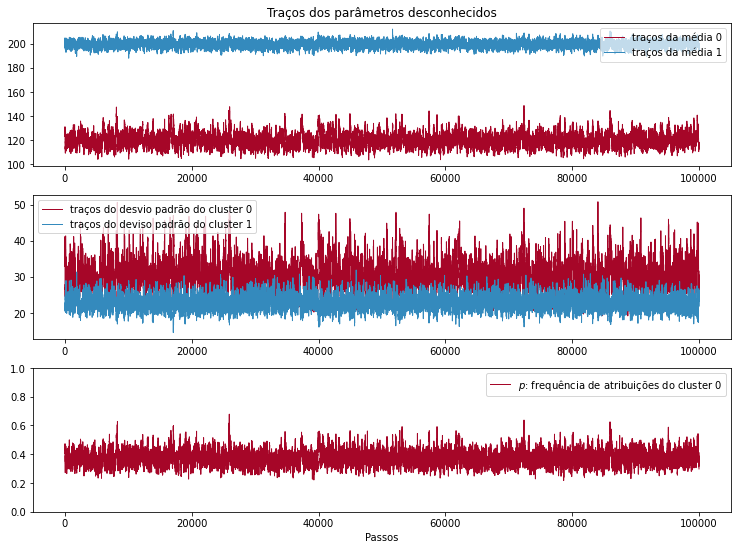

In [58]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# para cores bonitas mais tarde no livro.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="traços da média 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="traços da média 1", c=colors[1], lw=lw)
plt.title("Traços dos parâmetros desconhecidos")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="traços do desvio padrão do cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="traços do deviso padrão do cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequência de atribuições do cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Passos")
plt.ylim(0, 1)
plt.legend();


Observe as seguintes características:

1. Os traços convergem, não para um único ponto, mas para uma *distribuição* de pontos possíveis. Isso é *convergência* em um algoritmo MCMC.
2. Na inferência, usar os primeiros milhares de pontos é uma má ideia, pois eles não estão relacionados com a distribuição final na qual estamos interessados. Portanto, é uma boa ideia descartar essas amostras antes de usar as amostras para inferência. Chamamos esse período antes da convergência de *período de burn-in $^1$*.
3. Os traços aparecem como um "passeio" aleatório pelo espaço, ou seja, os caminhos apresentam correlações com as posições anteriores. Isso é bom e ruim. Sempre teremos correlações entre as posições atuais e as anteriores, mas muito disso significa que não estamos explorando bem o espaço. Isso será detalhado na seção Diagnósticos posteriormente, ainda neste capítulo.


Para alcançar maior convergência, realizaremos mais etapas MCMC. No algoritmo de pseudo-código do MCMC acima, a única posição que importa é a posição atual (novas posições são investigadas perto da posição atual), armazenada implicitamente como parte do objeto `trace`. Para continuar de onde paramos, passamos o `trace` que já armazenamos na função `sample()` com o mesmo valor de passo. Os valores que já calculamos não serão substituídos. Isso garante que nossa amostragem continue de onde parou da mesma forma que parou.

Vamos experimentar o MCMC mais cinquenta mil vezes e visualizar o progresso abaixo:

----
$^1 \mbox{(Nota do Tradutor): }$ *Período de burn-in* (período de queima), pode ser entendido como período inicial que será descartado.

In [59]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]


Sampling 4 chains for 1_000 tune and 75_000 draw iterations (4_000 + 300_000 draws total) took 2409 seconds.
The number of effective samples is smaller than 10% for some parameters.


ValueError: x and y must have same first dimension, but have shapes (50000,) and (275000,)

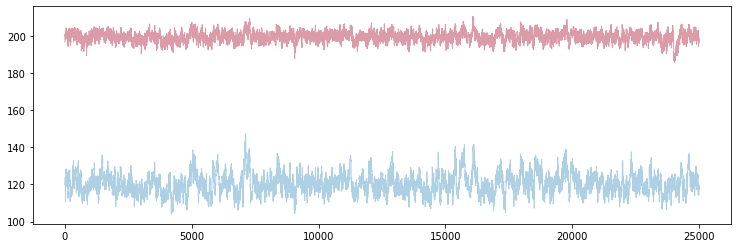

In [60]:
figsize(12.5, 4)
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="Traços anteriores do centro (media) 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="Traços anteriores do centro (media) 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="Novos traços dos centros 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="Novos traços dos centros 1", lw=lw, c="#A60628")

plt.title("Traços centrais dos parâmetros desconhecidos")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Passos");


####  Investigação dos Cluster

Não esquecemos o nosso principal desafio: identificar os clusters. Determinamos distribuições a posteriori para nossos desconhecidos. Plotamos as distribuições a posteriori das variáveis de centro (média) e desvio padrão abaixo:

In [ ]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posteriori do centro do cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior do desvio padrão do cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


O algoritmo MCMC propôs que os centros mais prováveis dos dois clusters estão próximos a 120 e 200, respectivamente. Inferências semelhantes podem ser aplicadas ao desvio padrão.

Também recebemos as distribuições a posteriori para os rótulos do ponto, que está presente em `trace ["assignment"]`. Abaixo está uma visualização disso. O eixo y representa uma subamostra dos rótulos posteriores para cada ponto de dados. O eixo x são os valores classificados dos pontos. Um quadrado vermelho é uma atribuição para o cluster 1 e um quadrado azul é uma atribuição para o cluster 0.

In [ ]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("Amostras a posterioris")
plt.xlabel("Valor do $i$-ésimo ponto")
plt.title("Rótulos dos pontos a posteriori");


Olhando para o gráfico acima, parece que a maior incerteza está entre 150 e 170. O gráfico acima representa um pouco mal as coisas, já que o eixo x não é uma escala verdadeira (ele exibe o valor do *i*-ésimo ponto classificado.) Um diagrama mais claro está abaixo, onde estimamos a *frequência* de cada ponto pertencente aos rótulos 0 e 1.

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probabilidade do ponto pertencer ao cluster 0")
plt.ylabel("probabilidade")
plt.xlabel("Valor do Ponto");


Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that *best* fits the data (whatever our definition of best is), but a distribution of values for the Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian? 

One quick and dirty way (which has nice theoretical properties we will see in Chapter 5), is to use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

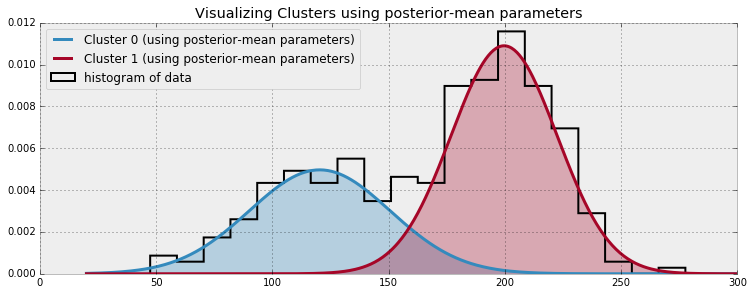

In [15]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");


### Important: Don't mix posterior samples

In the above example, a possible (though less likely) scenario is that cluster 0 has a very large standard deviation, and cluster 1 has a small standard deviation. This would still satisfy the evidence, albeit less so than our original inference. Alternatively, it would be incredibly unlikely for *both* distributions to have a small standard deviation, as the data does not support this hypothesis at all. Thus the two standard deviations are *dependent* on each other: if one is small, the other must be large. In fact, *all* the unknowns are related in a similar manner. For example, if a standard deviation is large, the mean has a wider possible space of realizations. Conversely, a small standard deviation restricts the mean to a small area. 

During MCMC, we are returned vectors representing samples from the unknown posteriors. Elements of different vectors cannot be used together, as this would break the above logic: perhaps a sample has returned that cluster 1 has a small standard deviation, hence all the other variables in that sample would incorporate that and be adjusted accordingly. It is easy to avoid this problem though, just make sure you are indexing traces correctly. 

Another small example to illustrate the point. Suppose two variables, $x$ and $y$, are related by $x+y=10$. We model $x$ as a Normal random variable with mean 4 and explore 500 samples.  

 [-------100%-------] 10000 of 10000 in 0.9 sec. | SPS: 11550.9 | ETA: 0.0

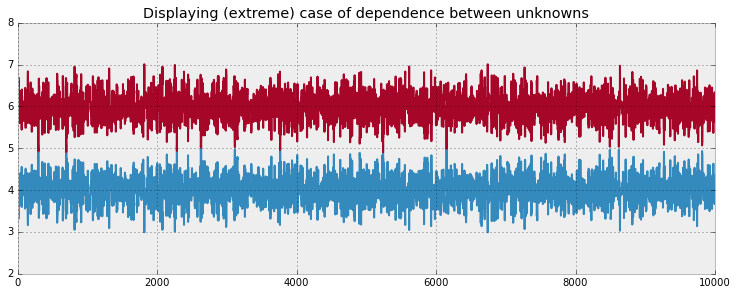

In [16]:
import pymc3 as pm

with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");


As you can see, the two variables are not unrelated, and it would be wrong to add the $i$th sample of $x$ to the $j$th sample of $y$, unless $i = j$.

#### Returning to Clustering: Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots. 

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method. 

We will use Bayes Theorem for this. If you recall, Bayes Theorem looks like:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "Is the probability that $x$ is in cluster 1 *greater* than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult). 

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$







In [17]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())


Probability of belonging to cluster 1: 0.01062


Giving us a probability instead of a label is a very useful thing. Instead of the naive 

    L = 1 if prob > 0.5 else 0

we can optimize our guesses using a *loss function*, which the entire fifth chapter is devoted to.  


### Using `MAP` to improve convergence

If you ran the above example yourself, you may have noticed that our results were not consistent: perhaps your cluster division was more scattered, or perhaps less scattered. The problem is that our traces are a function of the *starting values* of the MCMC algorithm. 

It can be mathematically shown that letting the MCMC run long enough, by performing many steps, the algorithm *should forget its initial position*. In fact, this is what it means to say the MCMC converged (in practice though we can never achieve total convergence). Hence if we observe different posterior analysis, it is likely because our MCMC has not fully converged yet, and we should not use samples from it yet (we should use a larger burn-in period ).

In fact, poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the *peak* of our landscape, as this is exactly where the posterior distributions exist. Hence, if we started at the "peak", we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this "peak" the *maximum a posterior* or, more simply, the *MAP*.

Of course, we do not know where the MAP is. PyMC3 provides a function that will approximate, if not find, the MAP location. In the PyMC3 main namespace is the `find_MAP` function. If you call this function within the context of `Model()`, it will calculate the MAP which you can then pass to `pm.sample()` as a `start` parameter.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

The `find_MAP()` function has the flexibility of allowing the user to choose which optimization algorithm to use (after all, this is a optimization problem: we are looking for the values that maximize our landscape), as not all optimization algorithms are created equal. The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) algorithm to find the maximum of the log-posterior. As an alternative, you can use other optimization algorithms from the `scipy.optimize` module. For example, you can use Powell's Method, a favourite of PyMC blogger [Abraham Flaxman](http://healthyalgorithms.com/) [1], by calling `find_MAP(fmin=scipy.optimize.fmin_powell)`. The default works well enough, but if convergence is slow or not guaranteed, feel free to experiment with Powell's method or the other algorithms available. 

The MAP can also be used as a solution to the inference problem, as mathematically it  is the *most likely* value for the unknowns. But as mentioned earlier in this chapter,  this location ignores the uncertainty and doesn't return a distribution.

#### Speaking of the burn-in period

It is still a good idea to decide on a burn-in period, even if we are using `find_MAP()` prior to sampling, just to be safe. We can no longer automatically discard sample with a `burn` parameter in the `sample()` function as we could in PyMC2, but it is easy enough to simply discard the beginning section of the trace just through array slicing. As one does not know when the chain has fully converged, a good rule of thumb is to discard the first *half* of your samples, sometimes up to 90% of the samples for longer runs. To continue the clustering example from above, the new code would look something like:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, start=start)
    
    burned_trace = trace[50000:]


## Diagnosing Convergence

### Autocorrelation

Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_\tau$, at time $t$ is with the series at time $t-k$:

$$R(k) = Corr( x_t, x_{t-k} ) $$

For example, consider the two series:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

which have example paths like:

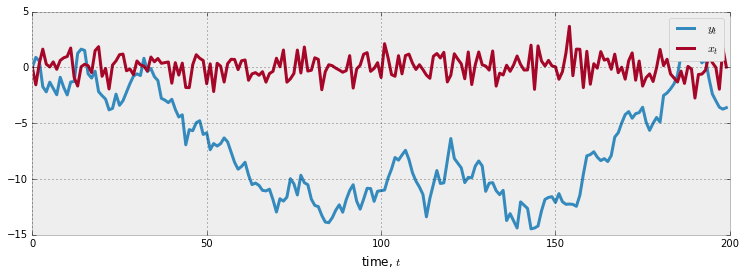

In [18]:
figsize(12.5, 4)

import pymc3 as pm
x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();


One way to think of autocorrelation is "If I know the position of the series at time $s$, can it help me know where I am at time $t$?" In the series $x_t$, the answer is No. By construction, $x_t$ are random variables. If I told you that $x_2 = 0.5$, could you give me a better guess about $x_3$? No.

On the other hand, $y_t$ is autocorrelated. By construction, if I knew that $y_2 = 10$, I can be very confident that $y_3$ will not be very far from 10. Similarly, I can even make a (less confident guess) about $y_4$: it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about $y_5$, but again, I am less confident. Taking this to it's logical conclusion, we must concede that as $k$, the lag between time points, increases the autocorrelation decreases. We can visualize this:


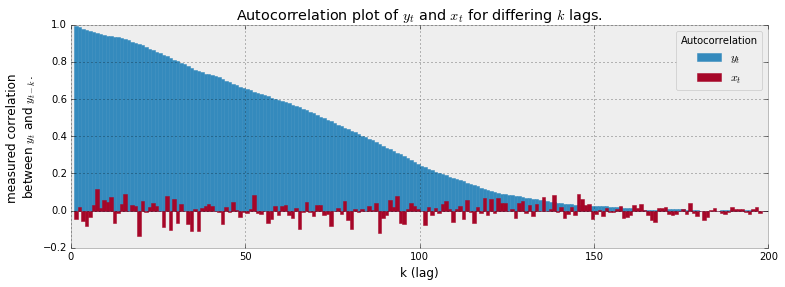

In [19]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");


Notice that as $k$ increases, the autocorrelation of $y_t$ decreases from a very high point. Compare with the autocorrelation of $x_t$ which looks like noise (which it really is), hence we can conclude no autocorrelation exists in this series. 


#### How does this relate to MCMC convergence?

By the nature of the MCMC algorithm, we will always be returned samples that exhibit autocorrelation (this is because of the step `from your current position, move to a position near you`).

A chain that is not exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.

This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. PyMC3 has a built-in autocorrelation plotting function in the `plots` module. 

### Thinning

Another issue can arise if there is high-autocorrelation between posterior samples. Many post-processing algorithms require samples to be *independent* of each other. This can be solved, or at least reduced, by only returning to the user every $n$th sample, thus removing some autocorrelation. Below we perform an autocorrelation plot for $y_t$ with differing levels of thinning:

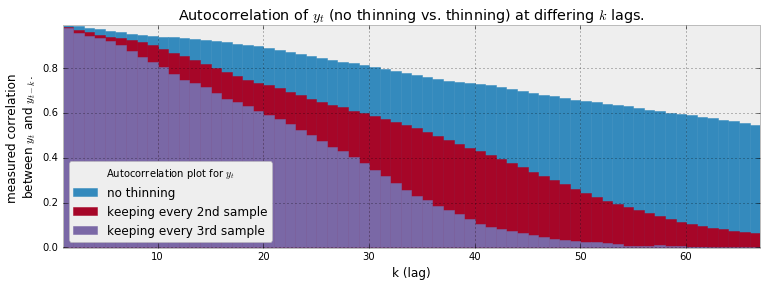

In [20]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");


With more thinning, the autocorrelation drops quicker. There is a tradeoff though: higher thinning requires more MCMC iterations to achieve the same number of returned samples. For example, 10 000 samples unthinned is 100 000 with a thinning of 10 (though the latter has less autocorrelation). 

What is a good amount of thinning? The returned samples will always exhibit some autocorrelation, regardless of how much thinning is done. So long as the autocorrelation tends to zero, you are probably ok. Typically thinning of more than 10 is not necessary.

### `pymc3.plots`

It seems silly to have to manually create histograms, autocorrelation plots and trace plots each time we perform MCMC. The authors of PyMC3 have included a visualization tool for just this purpose. 

The `pymc3.plots` module contains a few different plotting functions that you might find useful. For each different plotting function contained therein, you simply pass a `trace` returned from sampling as well as a list, `varnames`, of the variables that you are interested in. This module can provide you with plots of autocorrelation and the posterior distributions of each variable and their traces, among others.

Below we use the tool to plot the centers of the clusters.

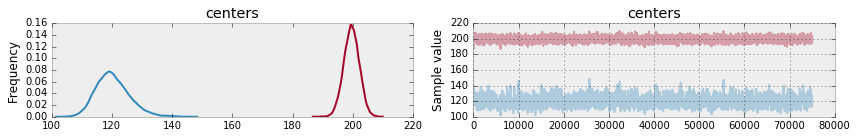

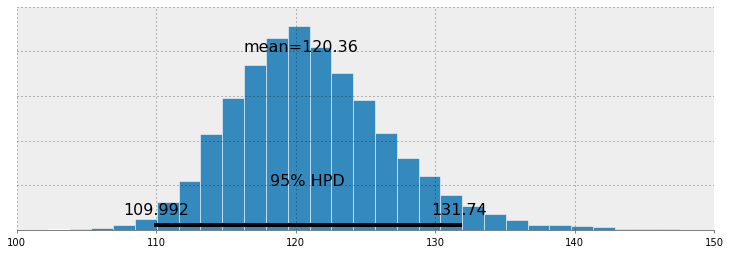

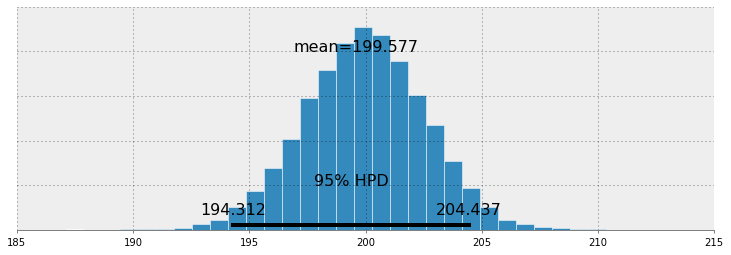

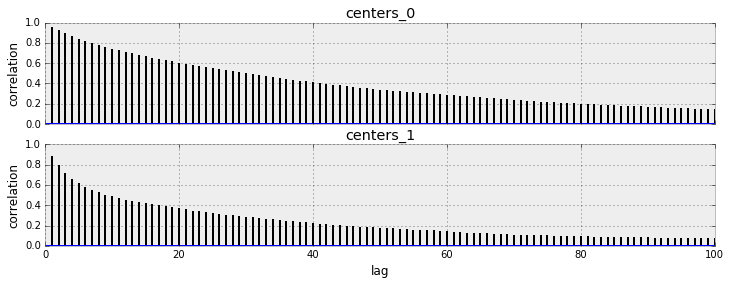

In [21]:
pm.plots.traceplot(trace=trace, varnames=["centers"])
pm.plots.plot_posterior(trace=trace["centers"][:,0])
pm.plots.plot_posterior(trace=trace["centers"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

The first plotting function gives us the posterior density of each unknown in the `centers` variable as well as the `trace` of each. `trace` plot is useful for inspecting that possible "meandering" property that is a result of non-convergence. The density plot gives us an idea of the shape of the distribution of each unknown, but it is better to look at each of them individually.

The second plotting function(s) provides us with a histogram of the samples with a few added features. The text overlay in the center shows us the posterior mean, which is a good summary of posterior distribution. The interval marked by the horizontal black line overlay represents the *95% credible interval*, sometimes called the *highest posterior density interval* and not to be confused with a *95% confidence interval*. We won't get into the latter, but the former can be interpreted as "there is a 95% chance the parameter of interest lies in this interval". When communicating your results to others, it is incredibly important to state this interval. One of our purposes for studying Bayesian methods is to have a clear understanding of our uncertainty in unknowns. Combined with the posterior mean, the 95% credible interval provides a reliable interval to communicate the likely location of the unknown (provided by the mean) *and* the uncertainty (represented by the width of the interval).

The last plots, titled `center_0` and `center_1` are the generated autocorrelation plots, similar to the ones displayed above.

## Useful tips for MCMC

Bayesian inference would be the *de facto* method if it weren't for MCMC's computational difficulties. In fact, MCMC is what turns most users off practical Bayesian inference. Below I present some good heuristics to help convergence and speed up the MCMC engine:

### Intelligent starting values

It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we *think* the posterior distribution will be by specifying the `testval` parameter in the `Stochastic` variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the $\mu$ parameter, then a good starting value would be the *mean* of the data. 

     mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )

For most parameters in models, there is a frequentist estimate of it. These estimates are a good starting value for our MCMC algorithms. Of course, this is not always possible for some variables, but including as many appropriate initial values is always a good idea. Even if your guesses are wrong, the MCMC will still converge to the proper distribution, so there is little to lose.

This is what using `MAP` tries to do, by giving good initial values to the MCMC. So why bother specifying user-defined values? Well, even giving `MAP` good values will help it find the maximum a-posterior. 

Also important, *bad initial values* are a source of major bugs in PyMC3 and can hurt convergence.

#### Priors

If the priors are poorly chosen, the MCMC algorithm may not converge, or atleast have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to carefully choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors (see *Folk Theorem of Statistical Computing* below). 

#### Covariance matrices and eliminating parameters

### The Folk Theorem of Statistical Computing

>   *If you are having computational problems, probably your model is wrong.*


## Conclusion

PyMC3 provides a very strong backend to performing Bayesian inference, mostly because it has abstracted the inner mechanics of MCMC from the user. Despite this, some care must be applied to ensure your inference is not being biased by the iterative nature of MCMC. 

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [1]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
